# Convergence analysis for the standing mode example

Data for the standing mode wave:
$$
\begin{aligned}
&\textbf{Domain:} && \Omega = [0, 1] \times [0, 1] \\
&\textbf{Final time:} && T = 1.0 \\
&\textbf{Number of elements:} && N_{\text{el},x} = N_{\text{el},y} = 320 \\
&\textbf{Polynomial degree:} && r = 1 \\
&\textbf{Time step:} && \Delta t = 0.01 \\
&\textbf{Wave speed:} && c(x, y, t) = 1.0 \\
&\textbf{Source:} && f(x, y, t) = 0 \\
&\textbf{Initial displacement:} && u_0(x, y) = \sin(\pi x)\sin(\pi y) \\
&\textbf{Initial velocity:} && v_0(x, y) = 0 \\
&\textbf{Boundary conditions:} && g(x, y, t) = 0 \\
&\textbf{Time derivative of boundary:} && \frac{\partial g}{\partial t}(x, y, t) = 0 \\
&\textbf{Exact solution:} && u_{\text{exact}}(x, y, t) = \cos(\sqrt{2}\pi t)\sin(\pi x)\sin(\pi y) \\
\end{aligned}
$$


## Newmark

Diverging configurations are not shown in the plots.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as colors
import numpy as np

sns.set_theme(style="whitegrid")

# Threshold for flagging divergence
DIVERGENCE_THRESHOLD = 1.0e5

In [13]:
def filter_diverged(df, threshold=DIVERGENCE_THRESHOLD):
    """
    Remove rows where error >= threshold and report diverged configurations.
    Returns cleaned dataframe and list of diverged configs.
    """
    df = df.copy()
    diverged = []
    
    for col in ['rel_L2_error_final', 'rel_H1_error_final']:
        if col in df.columns:
            # Handle NaN and inf
            df[col] = df[col].replace([np.inf, -np.inf], threshold * 10)
            df[col] = df[col].fillna(threshold * 10)
    
    # Find diverged rows
    mask_diverged = (df['rel_L2_error_final'] >= threshold) | (df['rel_H1_error_final'] >= threshold)
    if mask_diverged.any():
        diverged = df[mask_diverged][['N_el_x', 'N_el_y', 'r', 'dt']].drop_duplicates().values.tolist()
    
    # Return cleaned (non-diverged) dataframe
    return df[~mask_diverged], diverged

def plot_lines_by_r(df, scheme_name, r_per_row=2):
    """Single-row layout (4x1 for r_per_row=2), grouped by metric: L2 then H1."""
    df_clean, diverged = filter_diverged(df)
    figs_local = []
    if df_clean.empty or 'r' not in df_clean.columns:
        return figs_local

    r_vals = sorted(df_clean['r'].unique())
    for k in range(0, len(r_vals), r_per_row):
        r_group = r_vals[k:k + r_per_row]
        ncols = len(r_group)

        fig, axes = plt.subplots(1, 2 * ncols, figsize=(5 * 2 * ncols, 5), sharex=False, sharey=False)
        axes = np.array(axes).reshape(1, -1)

        # Axes groups: share y within L2 and within H1
        l2_axes = [axes[0, j] for j in range(ncols)]
        h1_axes = [axes[0, ncols + j] for j in range(ncols)]
        for ax in l2_axes[1:]:
            ax.sharey(l2_axes[0])
        for ax in h1_axes[1:]:
            ax.sharey(h1_axes[0])

        for j, r_val in enumerate(r_group):
            sub = df_clean[df_clean['r'] == r_val].copy()
            if sub.empty:
                continue
            sub['h_label'] = sub['h'].astype(str)

            # Order: [L2(r1), L2(r2), ..., H1(r1), H1(r2), ...]
            ax_l2 = l2_axes[j]
            ax_h1 = h1_axes[j]

            l2_legend = 'full' if (j == 0) else False
            sns.lineplot(
                data=sub, x='dt', y='rel_L2_error_final',
                hue='h_label', style='h_label', dashes=False,
                ax=ax_l2, legend=l2_legend, linewidth=2, marker="o"
            )
            sns.lineplot(
                data=sub, x='dt', y='rel_H1_error_final',
                hue='h_label', style='h_label', dashes=False,
                ax=ax_h1, legend=False, linewidth=2, marker="o"
            )

            ax_l2.set_title(f'L2 (r={r_val})')
            ax_h1.set_title(f'H1 (r={r_val})')

            # Scales + x labels
            for ax in (ax_l2, ax_h1):
                ax.set_xscale('log'); ax.set_yscale('log')
                ax.set_xlabel('dt')

            # Keep only ONE y-label per metric group
            ax_l2.set_ylabel('rel L2 error' if j == 0 else '')
            ax_h1.set_ylabel('rel H1 error' if j == 0 else '')

        # Enforce identical y-limits within each metric (per r_group)
        sub_all = df_clean[df_clean['r'].isin(r_group)]
        l2v = sub_all['rel_L2_error_final'].to_numpy()
        l2v = l2v[np.isfinite(l2v) & (l2v > 0)]
        if l2v.size:
            lo, hi = float(l2v.min()), float(l2v.max())
            for ax in l2_axes:
                ax.set_ylim(lo * 0.8, hi * 1.25)
        h1v = sub_all['rel_H1_error_final'].to_numpy()
        h1v = h1v[np.isfinite(h1v) & (h1v > 0)]
        if h1v.size:
            lo, hi = float(h1v.min()), float(h1v.max())
            for ax in h1_axes:
                ax.set_ylim(lo * 0.8, hi * 1.25)

        # One legend below, dedup labels
        leg_ax = axes[0, 0]
        handles, labels = leg_ax.get_legend_handles_labels()
        if leg_ax.get_legend() is not None:
            leg_ax.get_legend().remove()
        for ax in axes.ravel():
            if ax.get_legend() is not None:
                ax.get_legend().remove()
        uniq = []
        seen = set()
        for h, l in zip(handles, labels):
            if l == 'h_label':
                continue
            if l in seen:
                continue
            seen.add(l)
            uniq.append((h, l))
        if uniq:
            h2, l2 = zip(*uniq)
            fig.legend(
                h2, l2, title='h',
                loc='lower center', bbox_to_anchor=(0.5, -0.02),
                ncol=min(len(l2), 6), frameon=True,
                borderaxespad=0.1, columnspacing=0.8, handletextpad=0.4
            )

        fig.suptitle(f'{scheme_name}: Error vs dt', y=0.9)
        fig.tight_layout(rect=[0, 0.06, 1, 0.94])
        figs_local.append(fig)
    return figs_local

def plot_heatmaps(df, scheme_name, r_per_row=2):
    """Single-row layout: group by metric (L2 then H1) + ONE shared colorbar."""
    df_clean, diverged = filter_diverged(df)
    if df_clean.empty:
        print(f"  (No valid data to plot after filtering)")
        return

    # Shared scale (report-friendly): one norm + one colorbar for both L2 and H1
    l2_min = df_clean['rel_L2_error_final'].min(); l2_max = df_clean['rel_L2_error_final'].max()
    h1_min = df_clean['rel_H1_error_final'].min(); h1_max = df_clean['rel_H1_error_final'].max()
    err_min = min(l2_min, h1_min)
    err_max = max(l2_max, h1_max)
    shared_norm = colors.LogNorm(vmin=err_min, vmax=err_max)

    r_vals = sorted(df_clean['r'].unique())
    for k in range(0, len(r_vals), r_per_row):
        r_group = r_vals[k:k + r_per_row]
        ncols = len(r_group)

        fig, axes = plt.subplots(1, 2 * ncols, figsize=(5 * 2 * ncols + 2, 4), sharex=False, sharey=True)
        axes = np.array(axes).reshape(1, -1)

        # Grouping: [L2(r1), L2(r2), ..., H1(r1), H1(r2), ...]
        l2_axes = [axes[0, j] for j in range(ncols)]
        h1_axes = [axes[0, ncols + j] for j in range(ncols)]

        for j, r_val in enumerate(r_group):
            sub = df_clean[df_clean['r'] == r_val].copy()
            if sub.empty:
                continue

            pivot_l2 = sub.pivot_table(index='h', columns='dt', values='rel_L2_error_final')
            pivot_h1 = sub.pivot_table(index='h', columns='dt', values='rel_H1_error_final')

            ax_l2 = l2_axes[j]
            ax_h1 = h1_axes[j]

            sns.heatmap(pivot_l2, ax=ax_l2, cmap='magma', norm=shared_norm, cbar=False)
            sns.heatmap(pivot_h1, ax=ax_h1, cmap='magma', norm=shared_norm, cbar=False)

            ax_l2.set_title(f'L2 (r={r_val})', fontsize=10)
            ax_h1.set_title(f'H1 (r={r_val})', fontsize=10)
            ax_l2.set_xlabel('dt'); ax_h1.set_xlabel('dt')
            ax_l2.set_ylabel('h' if j == 0 else '')
            ax_h1.set_ylabel('')

        # Small scheme title (like the lineplots)
        fig.suptitle(scheme_name, y=0.96, fontsize=12)

        # Tight intra-group spacing + small inter-group gap
        fig.subplots_adjust(top=0.86, right=0.86, wspace=0.08)
        group_gap = 0.03
        for ax in h1_axes:
            pos = ax.get_position()
            ax.set_position([pos.x0 + group_gap, pos.y0, pos.width, pos.height])

        # Shared colorbar (placed to the right of the shifted H1 group)
        sm = plt.cm.ScalarMappable(cmap='magma', norm=shared_norm)
        sm.set_array([])
        right_edge = max(ax.get_position().x1 for ax in h1_axes) if h1_axes else 0.86
        cax = fig.add_axes([min(0.97, right_edge + 0.02), 0.15, 0.02, 0.7])
        fig.colorbar(sm, cax=cax, label='relative error')

In [14]:
def _safe_slope_loglog(x, y):
    """Return slope of log(y) vs log(x) (least squares), or NaN if not enough points."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x = x[mask]; y = y[mask]
    if x.size < 2:
        return float('nan')
    lx = np.log(x); ly = np.log(y)
    A = np.vstack([lx, np.ones_like(lx)]).T
    m, _b = np.linalg.lstsq(A, ly, rcond=None)[0]
    return float(m)

def _ref_line(ax, x, x0, y0, p, label):
    x = np.asarray(x, dtype=float)
    y = y0 * (x / x0) ** p
    ax.plot(x, y, '--', linewidth=2, label=label)

def plot_spacetime_rates(df, scheme_name, err_col):
    """
    For each r:
      - plot error vs h at dt=min(dt) with reference h^r
      - plot error vs dt at h=min(h) with reference dt^2
    Also prints observed slopes.
    """
    dfc, _ = filter_diverged(df)
    if dfc.empty:
        print(f"[{scheme_name}] no data")
        return

    # Ensure numeric types
    dfc = dfc.copy()
    for c in ['h', 'dt', 'r', err_col]:
        dfc[c] = pd.to_numeric(dfc[c], errors='coerce')
    dfc = dfc.dropna(subset=['h', 'dt', 'r', err_col])

    r_vals = sorted(dfc['r'].unique())
    for r_val in r_vals:
        subr = dfc[dfc['r'] == r_val].copy()
        if subr.empty:
            continue

        dt_min = float(subr['dt'].min())
        h_min = float(subr['h'].min())

        sub_h = subr[subr['dt'] == dt_min].sort_values('h')
        sub_t = subr[subr['h'] == h_min].sort_values('dt')

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # ---- error vs h (dt fixed) ----
        ax = axes[0]
        ax.plot(sub_h['h'], sub_h[err_col], marker='o', linewidth=2, label=f'dt={dt_min:g}')
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xlabel('h'); ax.set_ylabel(err_col)
        ax.set_title(f"{scheme_name} | r={int(r_val)} | spatial (dt=min)")
        if len(sub_h) >= 2:
            slope_h = _safe_slope_loglog(sub_h['h'], sub_h[err_col])
            ax.text(0.02, 0.02, f"obs slope ~ {slope_h:.2f}", transform=ax.transAxes)
        # Reference h^r scaled on first point
        if len(sub_h) >= 1:
            x0 = float(sub_h['h'].iloc[0]); y0 = float(sub_h[err_col].iloc[0])
            _ref_line(ax, sub_h['h'].values, x0, y0, float(r_val), f"~ h^{int(r_val)}")
        ax.legend()

        # ---- error vs dt (h fixed) ----
        ax = axes[1]
        ax.plot(sub_t['dt'], sub_t[err_col], marker='o', linewidth=2, label=f'h={h_min:g}')
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xlabel('dt'); ax.set_ylabel(err_col)
        ax.set_title(f"{scheme_name} | r={int(r_val)} | temporal (h=min)")
        if len(sub_t) >= 2:
            slope_dt = _safe_slope_loglog(sub_t['dt'], sub_t[err_col])
            ax.text(0.02, 0.02, f"obs slope ~ {slope_dt:.2f}", transform=ax.transAxes)
        # Reference dt^2 scaled on first point
        if len(sub_t) >= 1:
            x0 = float(sub_t['dt'].iloc[0]); y0 = float(sub_t[err_col].iloc[0])
            _ref_line(ax, sub_t['dt'].values, x0, y0, 2.0, "~ dt^2")
        ax.legend()

        fig.tight_layout()

def plot_bound_c_hr_dt2(df, scheme_name, err_col):
    """Visual check of error <= C*(h^r + dt^2) by plotting err vs (h^r + dt^2)."""
    dfc, _ = filter_diverged(df)
    if dfc.empty:
        print(f"[{scheme_name}] no data")
        return

    dfc = dfc.copy()
    for c in ['h', 'dt', 'r', err_col]:
        dfc[c] = pd.to_numeric(dfc[c], errors='coerce')
    dfc = dfc.dropna(subset=['h', 'dt', 'r', err_col])

    r_vals = sorted(dfc['r'].unique())
    for r_val in r_vals:
        sub = dfc[dfc['r'] == r_val].copy()
        if sub.empty:
            continue
        x = (sub['h'] ** float(r_val) + sub['dt'] ** 2).to_numpy()
        y = sub[err_col].to_numpy()
        mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
        x = x[mask]; y = y[mask]
        if x.size == 0:
            continue

        C_est = float(np.max(y / x))

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.scatter(x, y, s=30, alpha=0.8, label='data')
        xs = np.geomspace(x.min(), x.max(), 100)
        ax.plot(xs, C_est * xs, '--', linewidth=2, label=f'C_est*(h^r+dt^2), C_est={C_est:.2e}')
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xlabel('h^r + dt^2')
        ax.set_ylabel(err_col)
        ax.set_title(f"{scheme_name} | r={int(r_val)} | bound check")
        ax.legend()
        fig.tight_layout()

In [15]:
csv_path = Path('convergence-newmark.csv')
df_newmark = pd.read_csv(csv_path)
# Drop duplicates keeping the last entry
df_newmark = df_newmark.drop_duplicates(subset=['h', 'N_el_x', 'N_el_y', 'r', 'dt', 'T', 'method', 'beta', 'gamma'], keep='last')

# Subsets for Newmark: beta = 0.25 and beta = 0.0
df_newmark_025 = df_newmark[df_newmark['beta'] == 0.25].copy()
df_newmark_000 = df_newmark[df_newmark['beta'] == 0.0].copy()
print('=== Newmark ===\n- beta=0.25 rows:', len(df_newmark_025), '\n- beta=0.0  rows:', len(df_newmark_000))

=== Newmark ===
- beta=0.25 rows: 50 
- beta=0.0  rows: 50


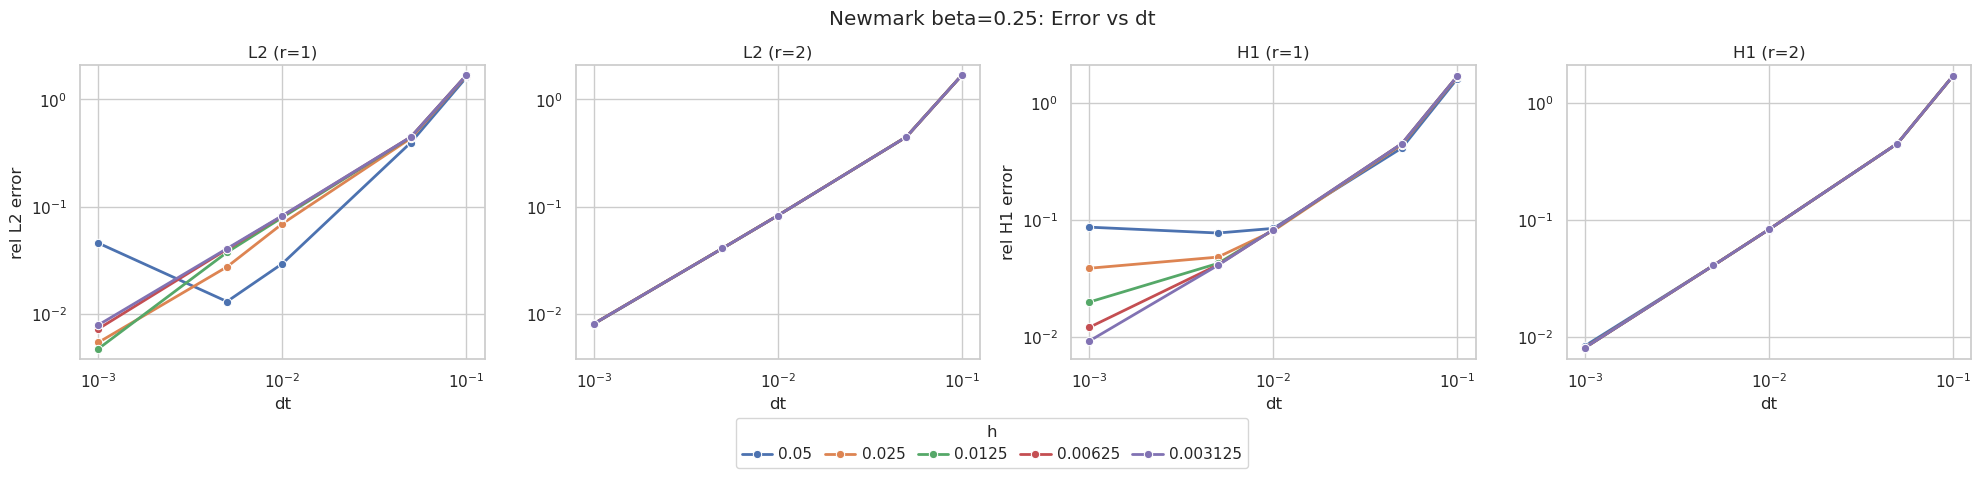

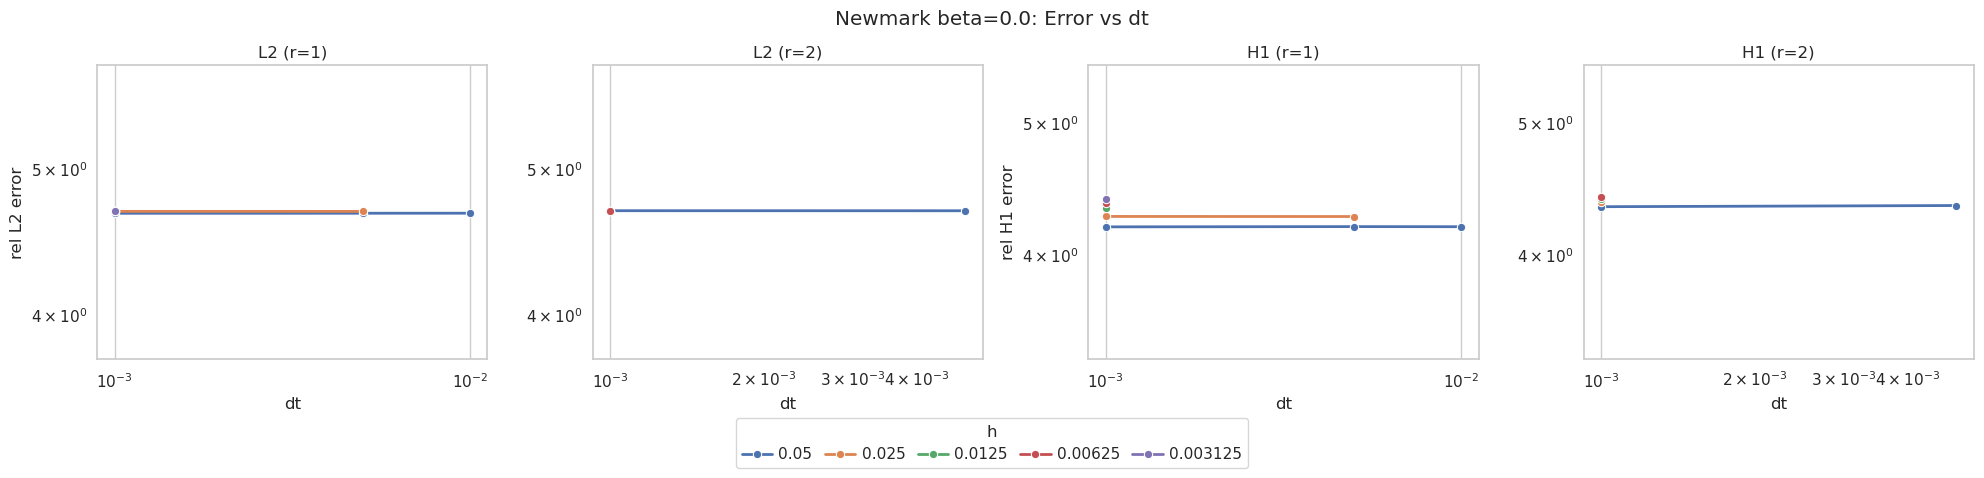

In [16]:
# Line charts for Newmark subsets
figs_nmk_025 = plot_lines_by_r(df_newmark_025, 'Newmark beta=0.25')
print()
figs_nmk_000 = plot_lines_by_r(df_newmark_000, 'Newmark beta=0.0')

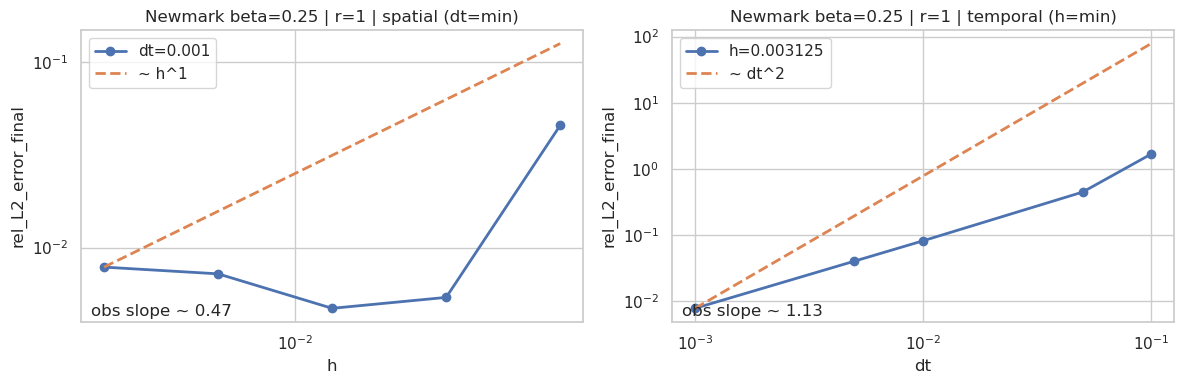

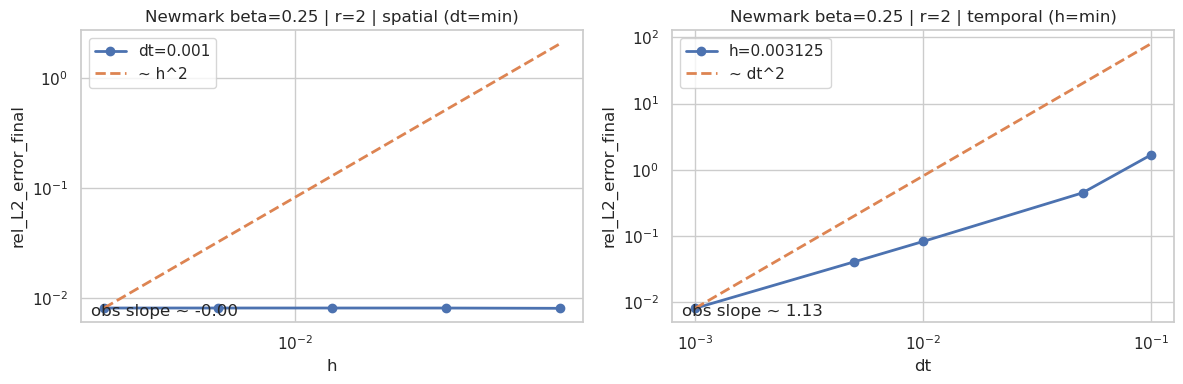

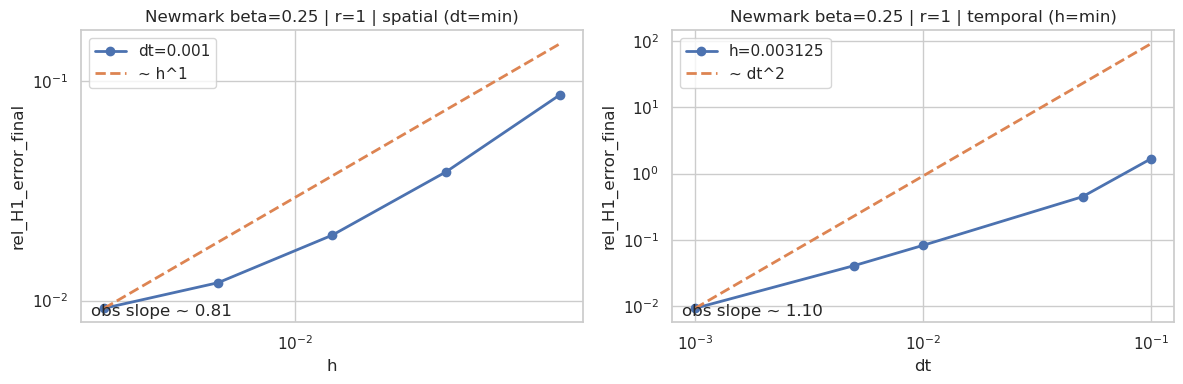

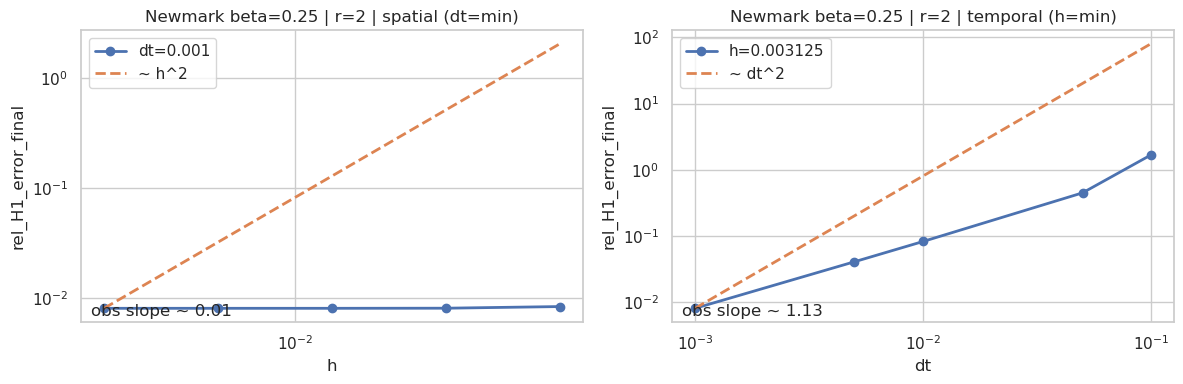

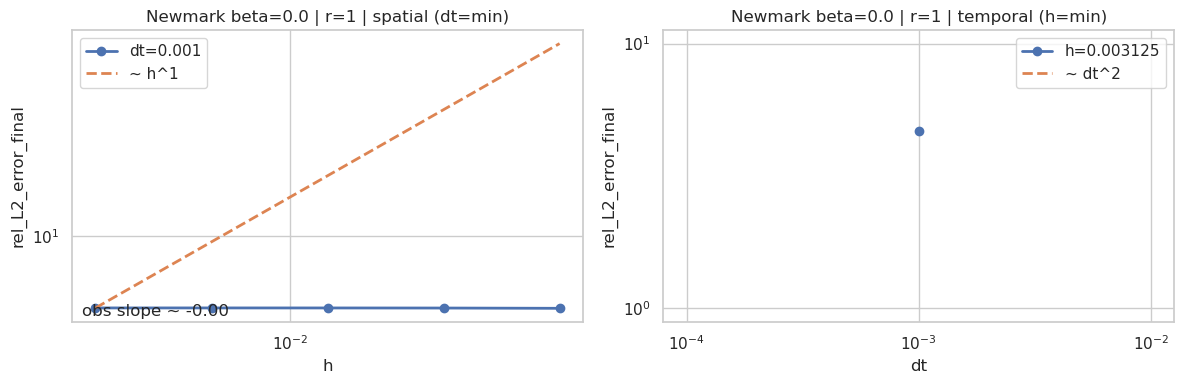

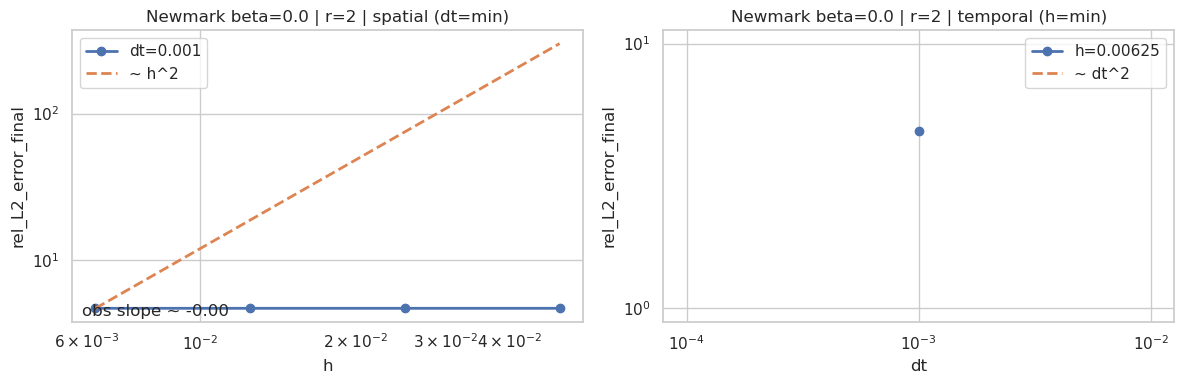

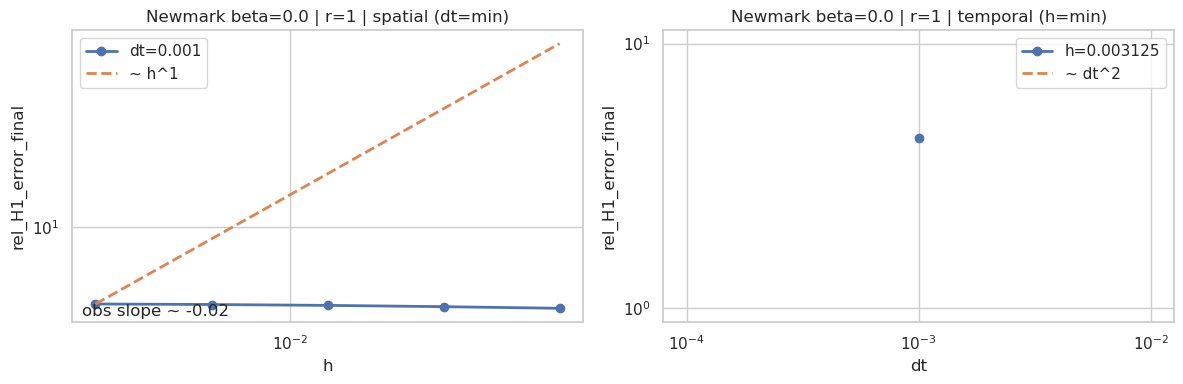

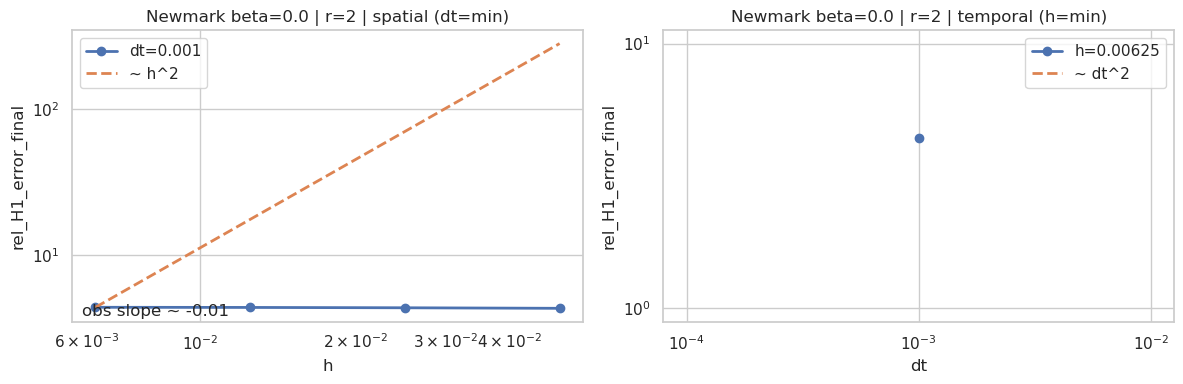

In [17]:
# Rate-style plots: isolate h^r and dt^2 behavior (Newmark)
plot_spacetime_rates(df_newmark_025, 'Newmark beta=0.25', 'rel_L2_error_final')
plot_spacetime_rates(df_newmark_025, 'Newmark beta=0.25', 'rel_H1_error_final')
# plot_bound_c_hr_dt2(df_newmark_025, 'Newmark beta=0.25', 'rel_L2_error_final')
# plot_bound_c_hr_dt2(df_newmark_025, 'Newmark beta=0.25', 'rel_H1_error_final')

plot_spacetime_rates(df_newmark_000, 'Newmark beta=0.0', 'rel_L2_error_final')
plot_spacetime_rates(df_newmark_000, 'Newmark beta=0.0', 'rel_H1_error_final')
# plot_bound_c_hr_dt2(df_newmark_000, 'Newmark beta=0.0', 'rel_L2_error_final')
# plot_bound_c_hr_dt2(df_newmark_000, 'Newmark beta=0.0', 'rel_H1_error_final')

In [18]:
# # Heatmaps for Newmark subsets
# plot_heatmaps(df_newmark_025, 'Newmark beta=0.25')
# print()
# plot_heatmaps(df_newmark_000, 'Newmark beta=0.0')

## Theta

In [19]:
csv_path_theta = Path('convergence-theta.csv')
df_theta = pd.read_csv(csv_path_theta)
# Drop duplicates keeping the last entry
df_theta = df_theta.drop_duplicates(subset=['h', 'N_el_x', 'N_el_y', 'r', 'dt', 'T', 'method', 'theta'], keep='last')

# Subsets per request: theta = 1.0 (BE), theta = 0.5 (CN), theta = 0.0 (FE)
df_theta_BE = df_theta[df_theta['theta'] == 1.0].copy()
df_theta_CN = df_theta[df_theta['theta'] == 0.5].copy()
df_theta_FE = df_theta[df_theta['theta'] == 0.0].copy()
print('=== Theta ===\n- FE (theta=0.0) rows:', len(df_theta_FE), '\n- CN (theta=0.5) rows:', len(df_theta_CN), '\n- BE (theta=1.0) rows:', len(df_theta_BE))

=== Theta ===
- FE (theta=0.0) rows: 50 
- CN (theta=0.5) rows: 50 
- BE (theta=1.0) rows: 50


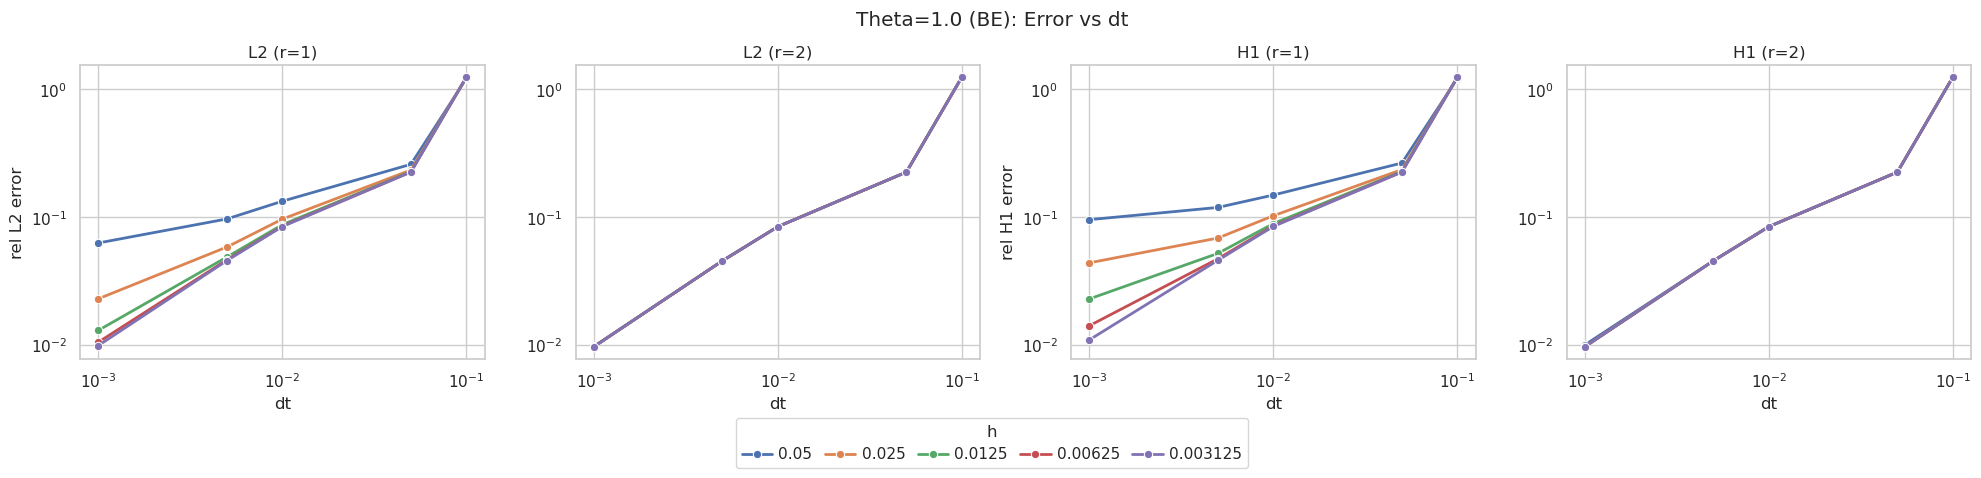

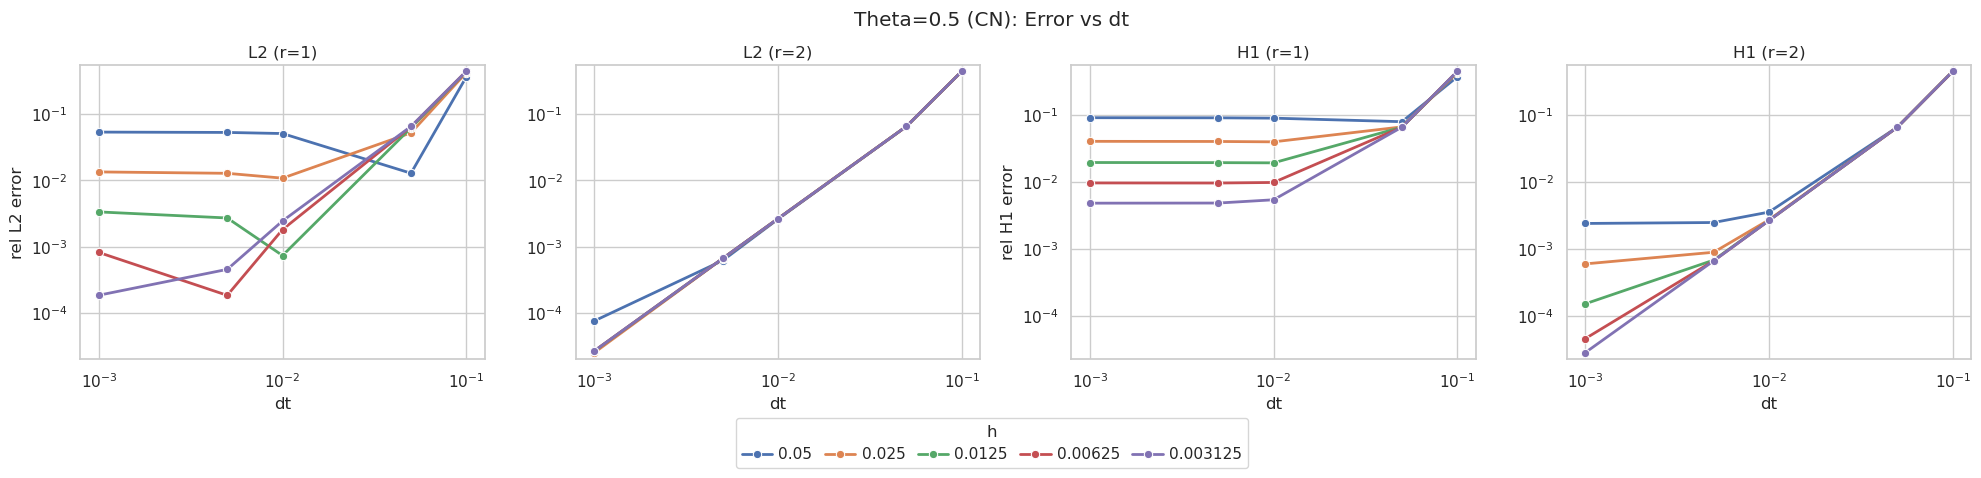

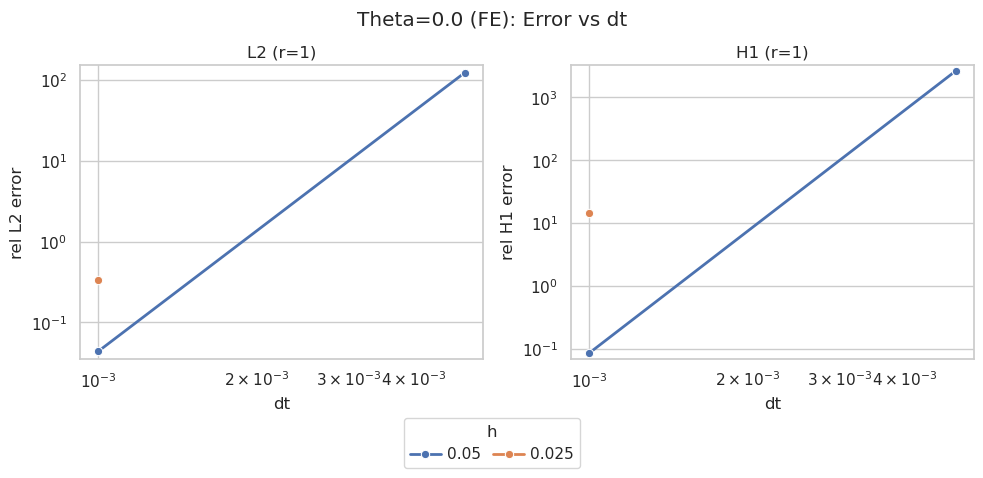

In [20]:
# Line charts for Theta subsets
figs_be = plot_lines_by_r(df_theta_BE, 'Theta=1.0 (BE)')
print()
figs_cn = plot_lines_by_r(df_theta_CN, 'Theta=0.5 (CN)')
print()
figs_fe = plot_lines_by_r(df_theta_FE, 'Theta=0.0 (FE)')

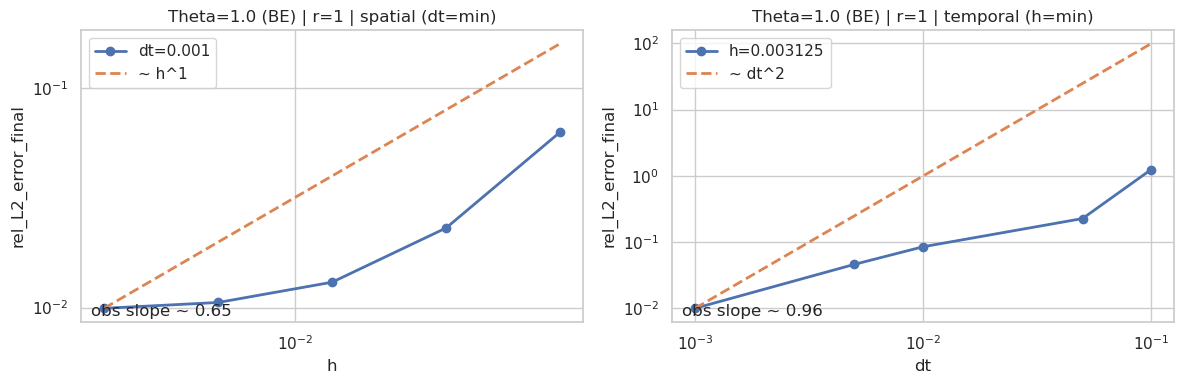

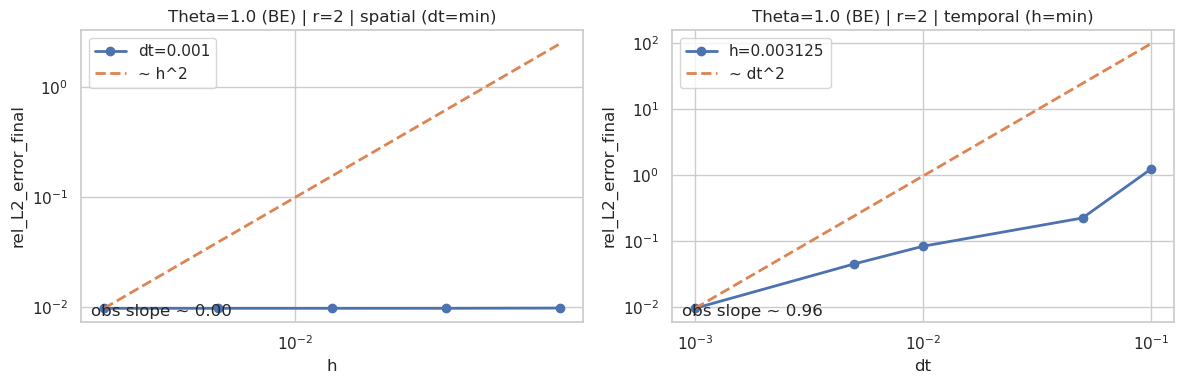

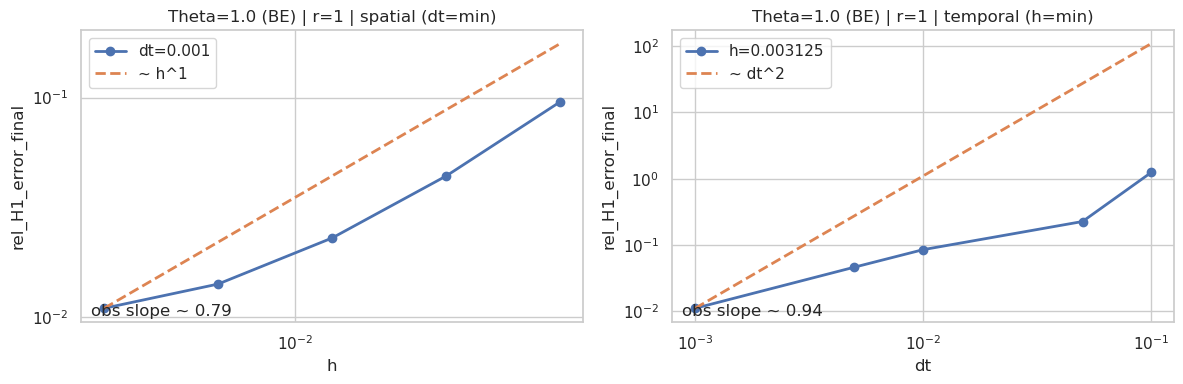

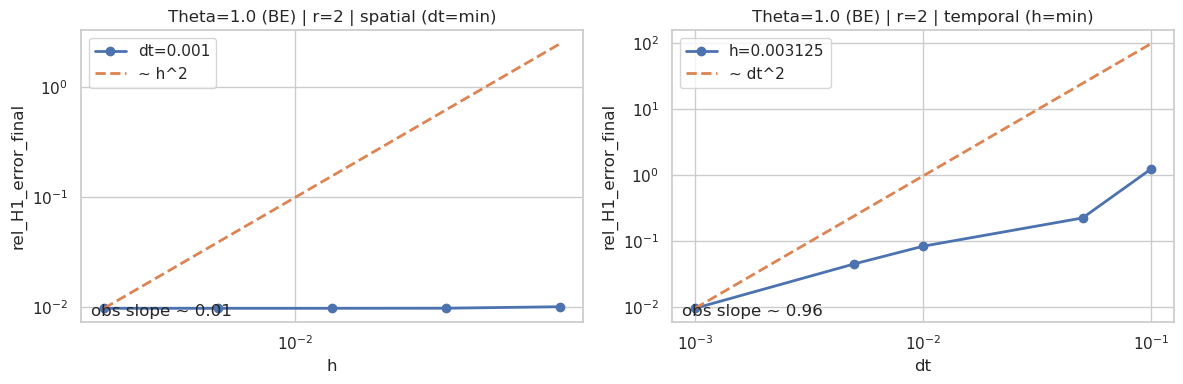

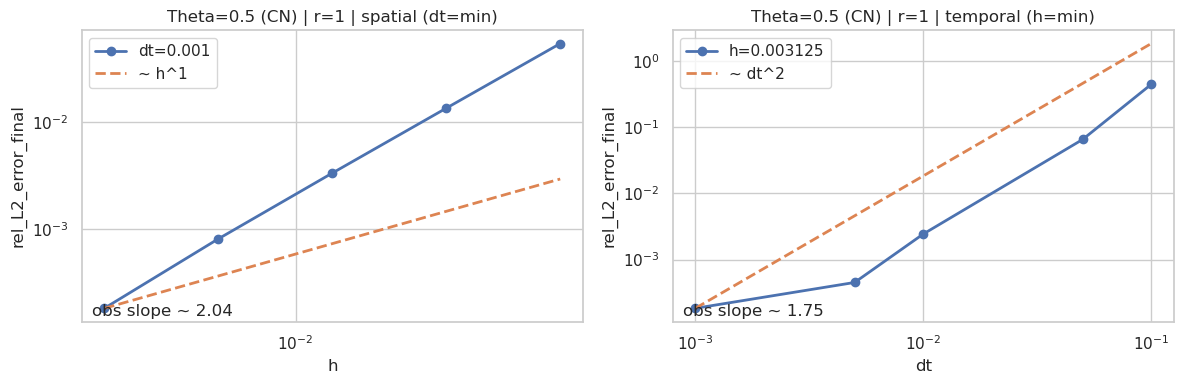

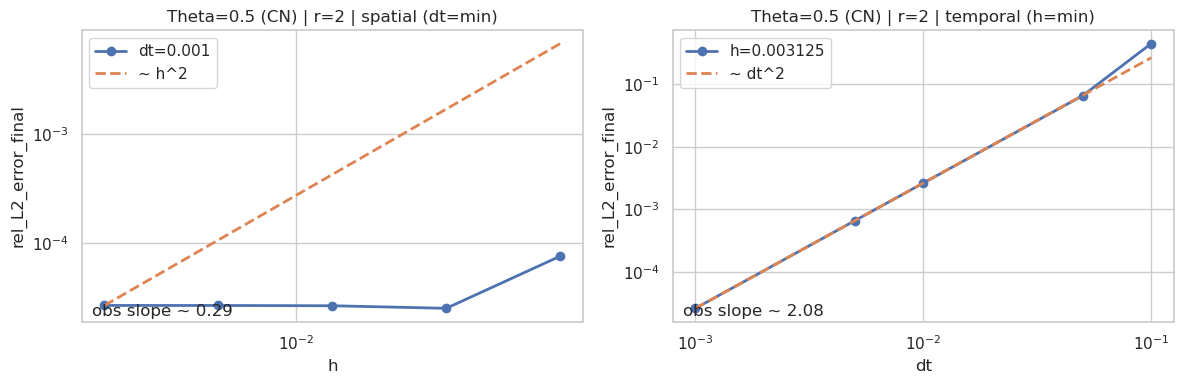

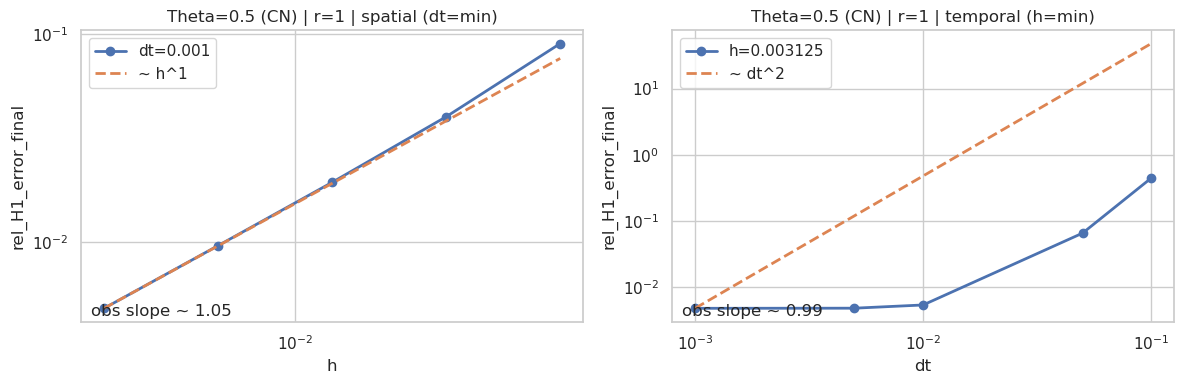

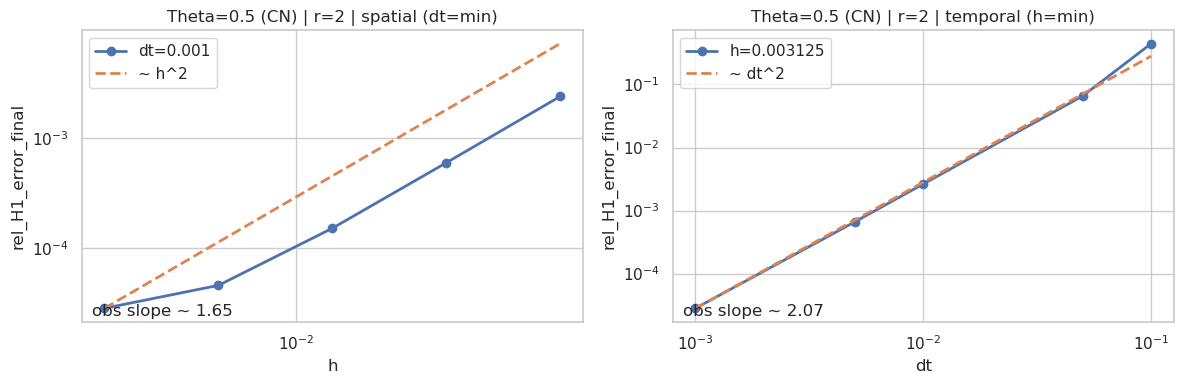

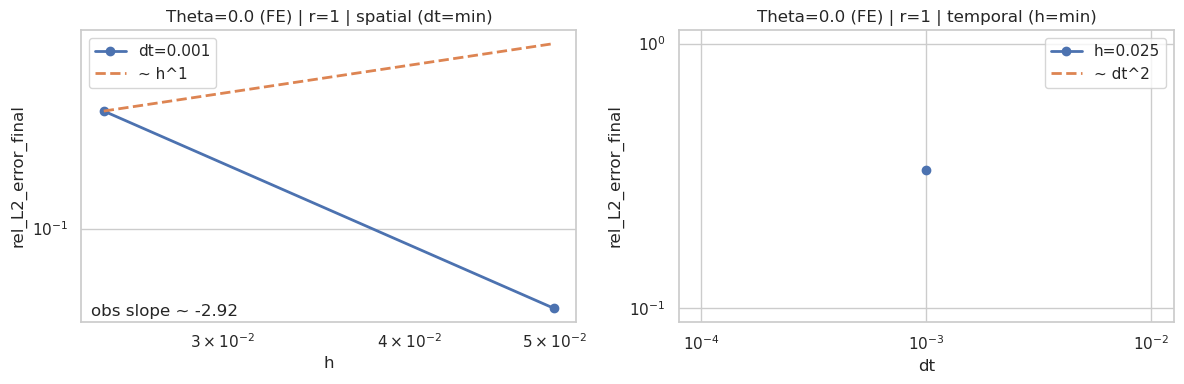

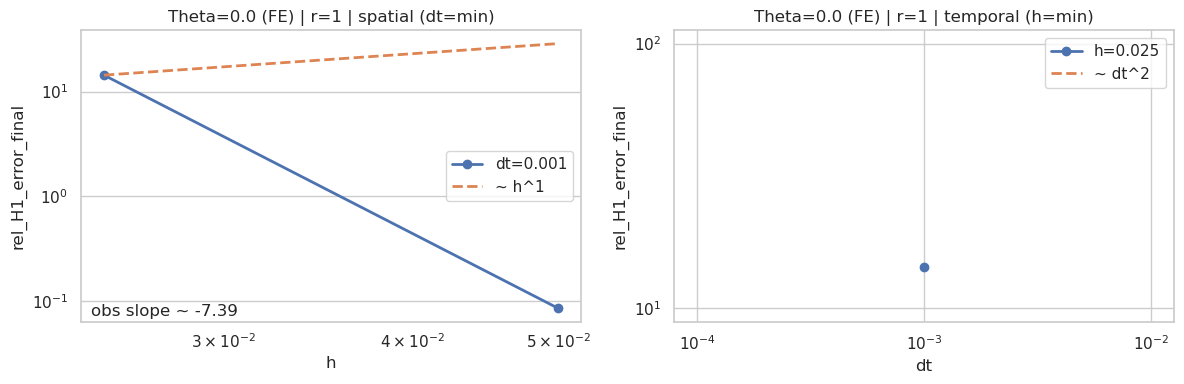

In [21]:
# Rate-style plots: isolate h^r and dt^2 behavior (Theta)
for dfi, name in [(df_theta_BE, 'Theta=1.0 (BE)'), (df_theta_CN, 'Theta=0.5 (CN)'), (df_theta_FE, 'Theta=0.0 (FE)')]:
    plot_spacetime_rates(dfi, name, 'rel_L2_error_final')
    plot_spacetime_rates(dfi, name, 'rel_H1_error_final')
    # plot_bound_c_hr_dt2(dfi, name, 'rel_L2_error_final')
    # plot_bound_c_hr_dt2(dfi, name, 'rel_H1_error_final')

In [22]:
# # Heatmaps for Theta subsets
# plot_heatmaps(df_theta_BE, 'Theta=1.0 (BE)')
# print()
# plot_heatmaps(df_theta_CN, 'Theta=0.5 (CN)')
# print()
# plot_heatmaps(df_theta_FE, 'Theta=0.0 (FE)')

In [23]:
def plot_collapsed_convergence(df, err_col, scheme_name):
    """
    Plots Error vs (h^s + dt^t) to verify the combined convergence rate.
    If the estimate holds, points should collapse onto a line with slope 1.
    
    Logic for orders:
      - Spatial (s): L2 -> r+1, H1 -> r
      - Temporal (t): Theta=0/1 -> 1, others (Newmark, CN) -> 2
    """
    df_clean, _ = filter_diverged(df)
    if df_clean.empty:
        print(f"[{scheme_name}] No valid data.")
        return

    # Determine spatial order offset
    if 'L2' in err_col:
        s_offset = 1
        metric_label = "L2"
    else:
        s_offset = 0
        metric_label = "H1"

    # Determine temporal order based on scheme name
    # Theta=1.0 (BE) and Theta=0.0 (FE) are 1st order in time.
    # Newmark and Theta=0.5 (CN) are 2nd order.
    if "Theta=1.0" in scheme_name or "Theta=0.0" in scheme_name:
        t_order = 1.0
    else:
        t_order = 2.0
    
    r_vals = sorted(df_clean['r'].unique())
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Collect all x, y for reference line scaling
    all_x, all_y = [], []

    for r_val in r_vals:
        sub = df_clean[df_clean['r'] == r_val].copy()
        if sub.empty:
            continue
        
        s_power = r_val + s_offset
        
        # The combined metric: h^(r+offset) + dt^t_order
        x_vals = sub['h']**s_power + sub['dt']**t_order
        y_vals = sub[err_col]
        
        all_x.extend(x_vals)
        all_y.extend(y_vals)
        
        sns.scatterplot(x=x_vals, y=y_vals, label=f'r={r_val}', ax=ax, s=50, alpha=0.8)

    if not all_x:
        return

    all_x = np.array(all_x)
    all_y = np.array(all_y)
    
    # 1. Reference line with slope 1 (Upper Bound)
    C_est = np.max(all_y / all_x)
    x_ref = np.geomspace(all_x.min(), all_x.max(), 50)
    y_ref = C_est * x_ref
    ax.plot(x_ref, y_ref, 'k--', alpha=0.6, label=f'Theoretical Slope 1')

    # 2. Best fit line (Observed Slope)
    mask = (all_x > 0) & (all_y > 0)
    if np.sum(mask) > 1:
        lx = np.log(all_x[mask])
        ly = np.log(all_y[mask])
        slope, intercept = np.polyfit(lx, ly, 1)
        
        y_fit = np.exp(intercept) * x_ref**slope
        ax.plot(x_ref, y_fit, 'r:', linewidth=2, label=f'Observed Slope ~ {slope:.2f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Dynamic label
    s_str = "r+1" if s_offset == 1 else "r"
    t_str = f"{int(t_order)}"
    ax.set_xlabel(f'$h^{{{s_str}}} + \\Delta t^{{{t_str}}}$')
    
    ax.set_ylabel(err_col)
    ax.set_title(f'{scheme_name}: Collapsed Convergence ({metric_label})')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

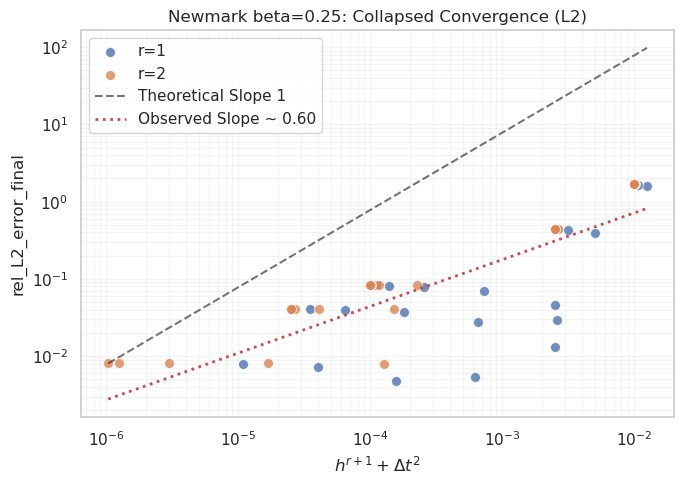

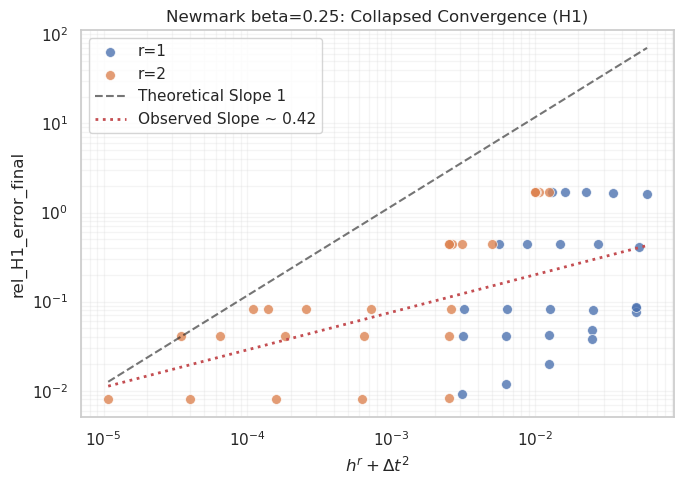

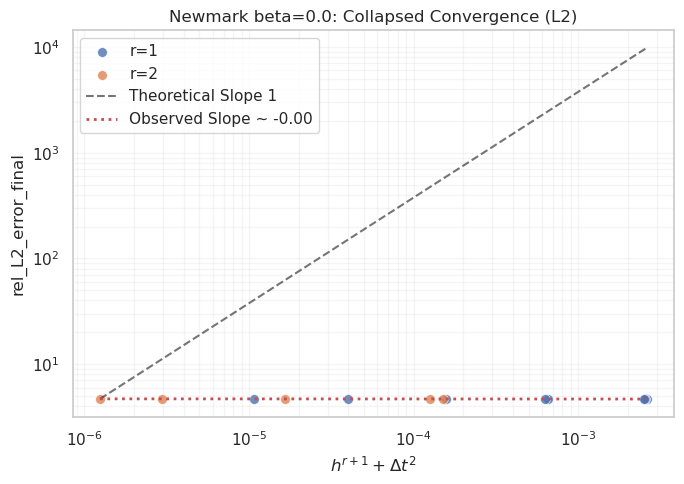

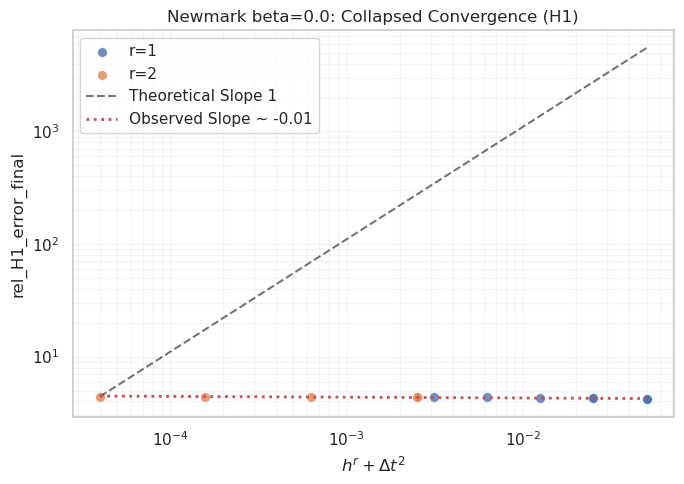

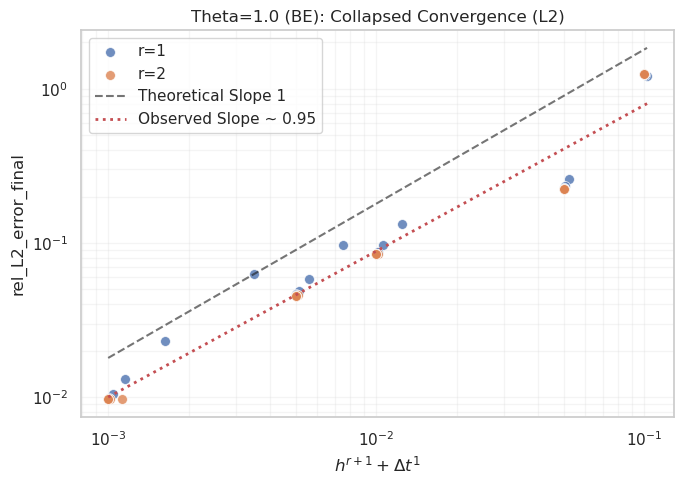

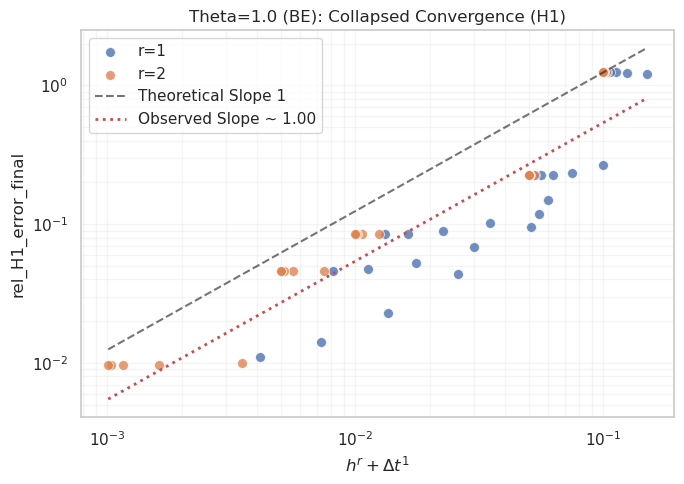

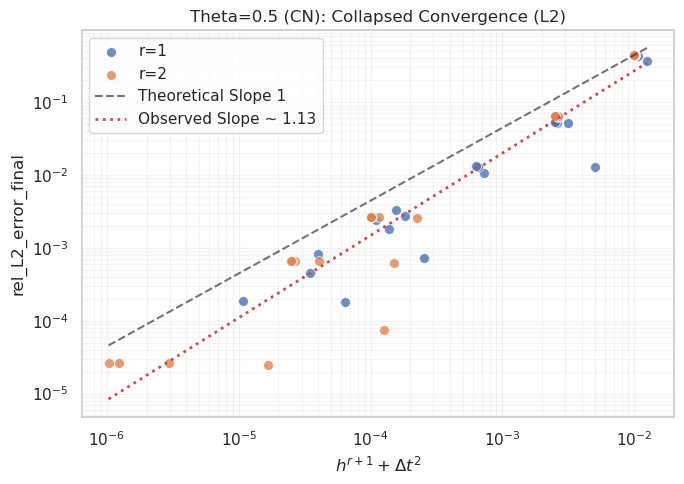

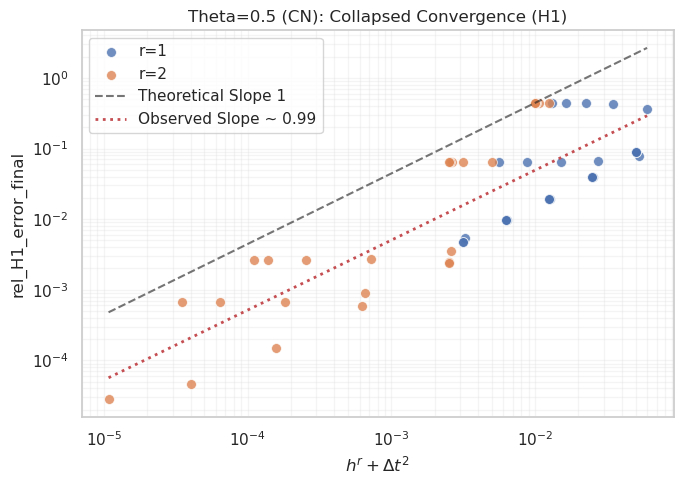

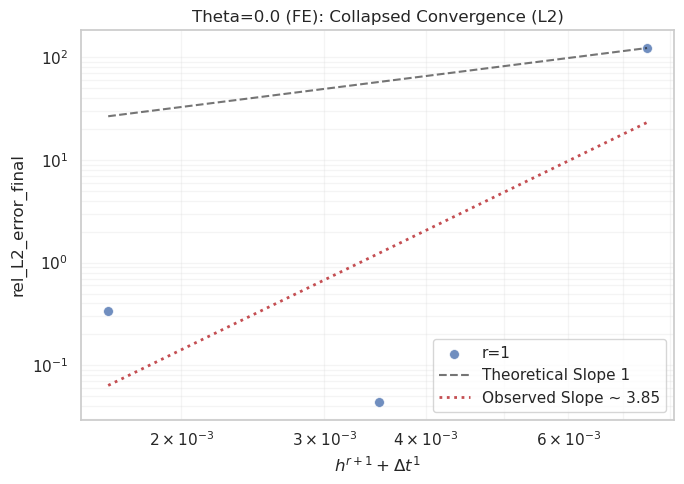

In [24]:
plot_collapsed_convergence(df_newmark_025, 'rel_L2_error_final', 'Newmark beta=0.25')
plot_collapsed_convergence(df_newmark_025, 'rel_H1_error_final', 'Newmark beta=0.25')
plot_collapsed_convergence(df_newmark_000, 'rel_L2_error_final', 'Newmark beta=0.0')
plot_collapsed_convergence(df_newmark_000, 'rel_H1_error_final', 'Newmark beta=0.0')
plot_collapsed_convergence(df_theta_BE, 'rel_L2_error_final', 'Theta=1.0 (BE)')
plot_collapsed_convergence(df_theta_BE, 'rel_H1_error_final', 'Theta=1.0 (BE)')
plot_collapsed_convergence(df_theta_CN, 'rel_L2_error_final', 'Theta=0.5 (CN)')
plot_collapsed_convergence(df_theta_CN, 'rel_H1_error_final', 'Theta=0.5 (CN)')
plot_collapsed_convergence(df_theta_FE, 'rel_L2_error_final', 'Theta=0.0 (FE)')